In [73]:
#first step: import libs and dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from itertools import product
import seaborn as sns
from datetime import date
import warnings

### RNN

In [86]:
# Import the dataset and encode the date
bit_data=pd.read_csv("./bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
bit_data["date"]=pd.to_datetime(bit_data["Timestamp"],unit="s").dt.date
group=bit_data.groupby("date")
data=group["Close"].mean()

In [88]:
# data.shape
data.head()

date
2011-12-31    4.482500
2012-01-01    4.806667
2012-01-02    5.000000
2012-01-03    5.252500
2012-01-04    5.223333
Name: Close, dtype: float64

In [89]:
#seperate
close_train=data.iloc[:len(data)-50]
close_test=data.iloc[len(close_train):]

In [90]:
#feature scalling (set values between 0-1)
close_train=np.array(close_train)
close_train=close_train.reshape(close_train.shape[0],1)
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
close_scaled=scaler.fit_transform(close_train)

In [91]:
timestep=50
x_train=[]
y_train=[]

for i in range(timestep,close_scaled.shape[0]):
    x_train.append(close_scaled[i-timestep:i,0])
    y_train.append(close_scaled[i,0])

x_train,y_train=np.array(x_train),np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1) #reshaped for RNN
print("x_train shape= ",x_train.shape)
print("y_train shape= ",y_train.shape)

x_train shape=  (3276, 50, 1)
y_train shape=  (3276,)


In [92]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout,Flatten

regressor=Sequential()
#first RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True,input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.25))
#second RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#third RNN layer
regressor.add(SimpleRNN(512,activation="relu",return_sequences=True))
regressor.add(Dropout(0.35))
#fourth RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#fifth RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#convert the matrix to 1-line
regressor.add(Flatten())
#output layer
regressor.add(Dense(1))

regressor.compile(optimizer="adam",loss="mean_squared_error")
regressor.fit(x_train,y_train,epochs=100,batch_size=64)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpj2ozwa65.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpj2ozwa65.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
52/52 [==============================] - 47s 399ms/step - loss: 0.0069
Epoch 2/100
52/52 [==============================] - 21s 395ms/step - loss: 0.0015
Epoch 3/100
52/52 [====

52/52 [==============================] - 23s 438ms/step - loss: 1.7297e-04
Epoch 82/100
52/52 [==============================] - 22s 417ms/step - loss: 2.3563e-04
Epoch 83/100
52/52 [==============================] - 22s 418ms/step - loss: 2.4615e-04
Epoch 84/100
52/52 [==============================] - 22s 419ms/step - loss: 1.6862e-04
Epoch 85/100
52/52 [==============================] - 22s 415ms/step - loss: 2.4659e-04
Epoch 86/100
52/52 [==============================] - 22s 422ms/step - loss: 2.4583e-04
Epoch 87/100
52/52 [==============================] - 23s 435ms/step - loss: 2.4888e-04
Epoch 88/100
52/52 [==============================] - 24s 454ms/step - loss: 1.8777e-04
Epoch 89/100
52/52 [==============================] - 20s 388ms/step - loss: 1.5303e-04
Epoch 90/100
52/52 [==============================] - 20s 394ms/step - loss: 1.5378e-04
Epoch 91/100
52/52 [==============================] - 21s 406ms/step - loss: 1.6238e-04
Epoch 92/100
52/52 [=========================

In [93]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [94]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [95]:
predicted_data=regressor.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

In [96]:
data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

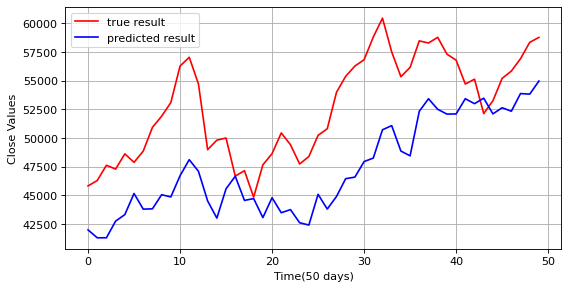

In [97]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

### LSTM

In [98]:
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten

model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

model.fit(x_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
103/103 [==============================] - 5s 13ms/step - loss: 0.0067
Epoch 2/100
103/103 [==============================] - 1s 14ms/step - loss: 3.0694e-04
Epoch 3/100
103/103 [==============================] - 1s 13ms/step - loss: 1.6625e-04
Epoch 4/100
103/103 [==============================] - 1s 13ms/step - loss: 1.6239e-04
Epoch 5/100
103/103 [==============================] - 1s 13ms/step - loss: 1.5550e-04
Epoch 6/100
103/103 [==============================] - 1s 13ms/step - loss: 1.5374e-04
Epoch 7/100
103/103 [==============================] - 1s 13ms/step - loss: 1.2165e-04
Epoch 8/100
103/103 [==============================] - 1s 13ms/step - loss: 1.0545e-04
Epoch 9/100
103/103 [==============================] - 1s 13ms/step - loss: 1.2834e-04
Epoch 10/100
103/103 [==============================] - 1s 13ms/step - loss: 1.1248e-04
Epoch 11/100
103/103 [==============================] - 1s 13ms/step - loss: 1.2369e-04
Epoch 12/100
103/103 [=======================

Epoch 94/100
103/103 [==============================] - 1s 13ms/step - loss: 5.0373e-05
Epoch 95/100
103/103 [==============================] - 1s 13ms/step - loss: 4.5378e-05
Epoch 96/100
103/103 [==============================] - 1s 13ms/step - loss: 5.6541e-05
Epoch 97/100
103/103 [==============================] - 1s 13ms/step - loss: 3.8074e-05
Epoch 98/100
103/103 [==============================] - 1s 13ms/step - loss: 4.8418e-05
Epoch 99/100
103/103 [==============================] - 1s 13ms/step - loss: 4.6124e-05
Epoch 100/100
103/103 [==============================] - 1s 13ms/step - loss: 5.5009e-05


In [99]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [100]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [101]:
predicted_data=model.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

In [102]:
data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

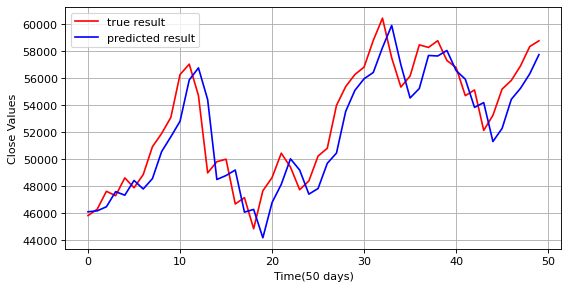

In [103]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

### ARIMA (SARIMAX)

In [6]:
df = pd.read_csv('./bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Unix-time to 
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159


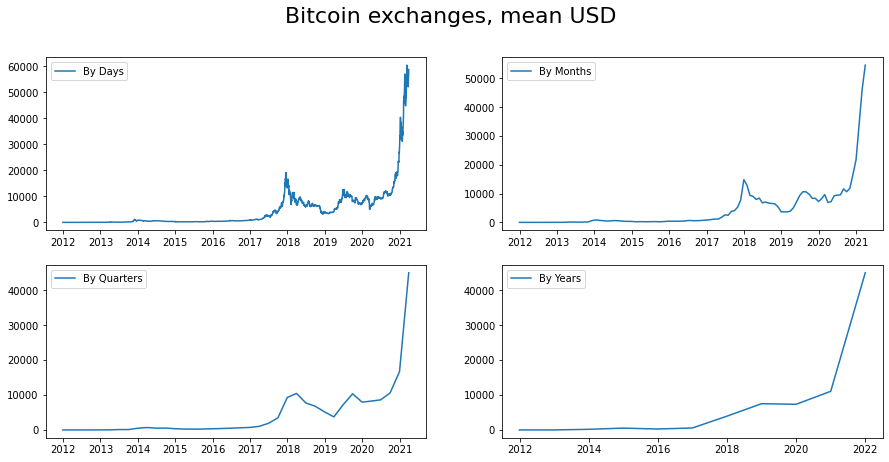

In [32]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

Dickey–Fuller test: p=0.998863


<Figure size 1080x504 with 0 Axes>

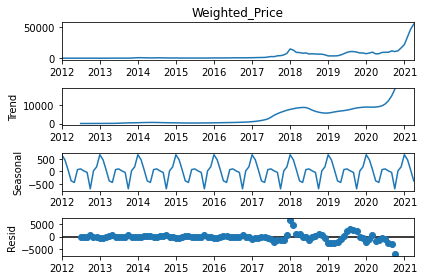

In [34]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show()

In [17]:
# Box-Cox Transformations
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

Dickey–Fuller test: p=0.998863


In [18]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.444282


Dickey–Fuller test: p=0.000024


<Figure size 1080x504 with 0 Axes>

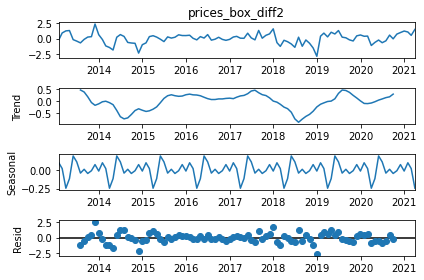

In [19]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

In [27]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [35]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  173.616444
21  (1, 0, 1, 1)  174.766384
25  (1, 1, 0, 1)  175.547496
37  (2, 0, 0, 1)  175.554276
7   (0, 1, 0, 1)  175.590671
                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                  112
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -83.808
Date:                              Tue, 11 May 2021   AIC                            173.616
Time:                                      11:57:06   BIC                            181.402
Sample:                                  12-31-2011   HQIC                           176.766
                                       - 03-31-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

In [29]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

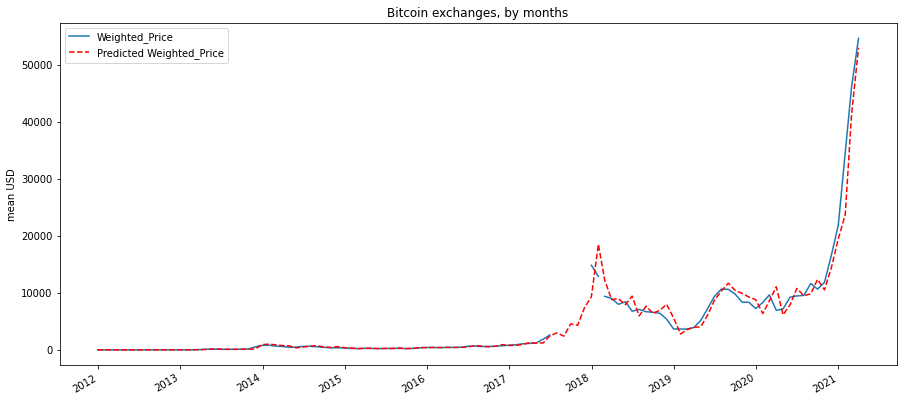

In [69]:
# Prediction
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2017, 6, 30), datetime(2017, 7, 31), datetime(2017, 8, 31), datetime(2017, 9, 30), 
             datetime(2017, 10, 31), datetime(2017, 11, 30), datetime(2017, 12, 31), datetime(2018, 1, 31),
             datetime(2018, 2, 28)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=120), lmbda)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()

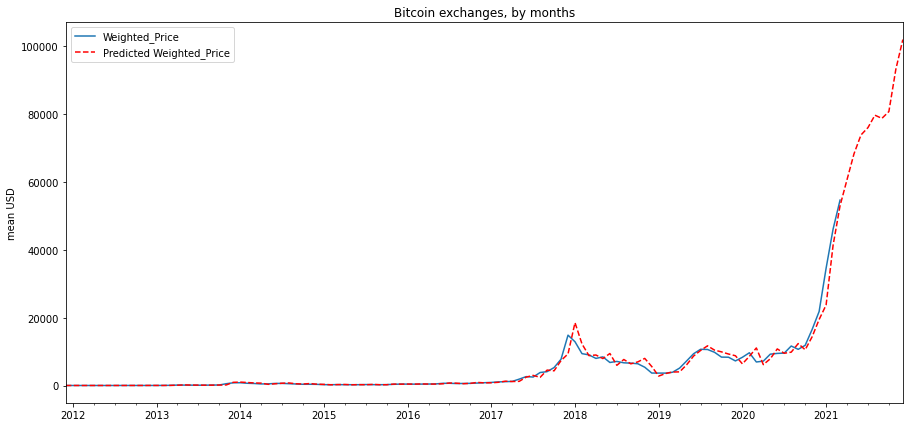

In [85]:
# Prediction
df_month2 = df_month[['Weighted_Price']]
# date_list = []
# for y in range(2021, 2022):
#     for m in range (1, 13):
#         if m == 2:
#             for d in range(1, 29):
#                 date_list.append(date(y,m,d))
#         elif m == 4 or m == 6 or m == 9 or m == 11:
#             for d in range(1, 31):
#                 date_list.append(date(y,m,d))
#         else:
#             for d in range(1, 32):
#                 date_list.append(date(y,m,d))
# # date_list
date_list = [#datetime(2017, 6, 30), datetime(2017, 7, 31), datetime(2017, 8, 31), datetime(2017, 9, 30), 
#              datetime(2017, 10, 31), datetime(2017, 11, 30), datetime(2017, 12, 31), datetime(2018, 1, 31),
#              datetime(2018, 2, 28), datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31),
#              datetime(2018, 6, 30), datetime(2018, 7, 31), datetime(2018, 8, 31), datetime(2018, 9, 30), 
#              datetime(2018, 10, 31), datetime(2018, 11, 30), datetime(2018, 12, 31), datetime(2019, 1, 31),
#              datetime(2019, 2, 28), datetime(2019, 3, 31), datetime(2019, 4, 30), datetime(2019, 5, 31),
#              datetime(2019, 6, 30), datetime(2019, 7, 31), datetime(2019, 8, 31), datetime(2019, 9, 30), 
#              datetime(2019, 10, 31), datetime(2019, 11, 30), datetime(2019, 12, 31), datetime(2020, 1, 31),
#              datetime(2020, 2, 28), datetime(2020, 3, 31), datetime(2020, 4, 30), datetime(2020, 5, 31),
#              datetime(2020, 6, 30), datetime(2020, 7, 31), datetime(2020, 8, 31), datetime(2020, 9, 30), 
#              datetime(2020, 10, 31), datetime(2020, 11, 30), datetime(2020, 12, 31), datetime(2021, 1, 31),
#              datetime(2021, 2, 28), datetime(2021, 3, 31), 
    datetime(2021, 4, 30), datetime(2021, 5, 31),
             datetime(2021, 6, 30), datetime(2021, 7, 31), datetime(2021, 8, 31), datetime(2021, 9, 30), 
             datetime(2021, 10, 31), datetime(2021, 11, 30), datetime(2021, 12, 31)]

future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=120), lmbda)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()